# Estimate position

## Imports and definitions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Reference features

In [3]:
ref_filename = '../50_cm.jpg'

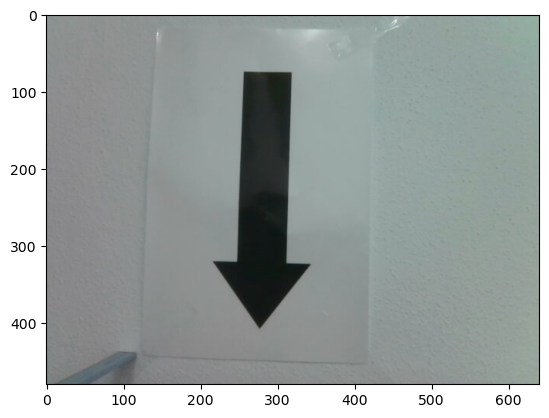

In [4]:
ref_img = cv2.imread(ref_filename)
if ref_img is not None:
    plt.imshow(ref_img)
    plt.show()

In [5]:
img_filename = ref_filename

load model...


2024-12-31 23:33:05.292456: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


loaded model
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
(1, 1)
[[0.99992114]]


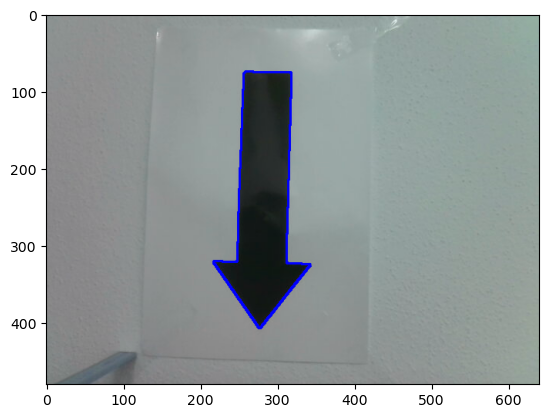

done


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

if not 'model' in dir():
    print('load model...')
    from keras.models import load_model
    model = load_model('arrow_detection.keras')
    print('loaded model')
    
else:
    print('model already loaded')
    
model.trainable = False

COMPARED_SIZE = (24, 68)
AREA_BORDER = COMPARED_SIZE[0] * COMPARED_SIZE[1]
WIDTH_TO_HEIGHT = COMPARED_SIZE[0] / COMPARED_SIZE[1]
SIZE_FACTOR = 0.3
MIN_WIDTH_TO_HEIGHT = WIDTH_TO_HEIGHT * (1 - SIZE_FACTOR)
MAX_WIDTH_TO_HEIGHT = WIDTH_TO_HEIGHT * (1 + SIZE_FACTOR)

def prepare_rotation(min_rect):
    """
    Prepare portrait rotation. No difference between up and down.
    """
    
    width_to_height = min_rect[1][0] / min_rect[1][1]
    
    if width_to_height >= 1:
        return 90 - min_rect[2]
    else:
        return min_rect[2]

def rotate_and_crop_min_rect(image, min_area_rect):
    factor = 1.3

    box = cv2.boxPoints(min_area_rect)
    box = np.intp(box)

    width = round(min_area_rect[1][0])
    height = round(min_area_rect[1][1])

    size_of_transformed_image = max(min_area_rect[1])
    min_needed_height = int(np.sqrt(2 * np.power(size_of_transformed_image, 2)))

    #angle = prepare_rotation(min_area_rect)
    width_to_height = min_area_rect[1][0] / min_area_rect[1][1]
    
    if width_to_height >= 1:
        angle = -1 * (90 - min_rect[2])
    else:
        angle = min_rect[2]    
        
    size = (min_needed_height, min_needed_height)

    x_coordinates_of_box = box[:,0]
    y_coordinates_of_box = box[:,1]
    x_min = min(x_coordinates_of_box)
    x_max = max(x_coordinates_of_box)
    y_min = min(y_coordinates_of_box)
    y_max = max(y_coordinates_of_box)

    center = (int((x_min+x_max)/2), int((y_min+y_max)/2))
    cropped = cv2.getRectSubPix(image, size, center) 
    M = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)
    cropped = cv2.warpAffine(cropped, M, size)
    
    if width_to_height >= 1:
        cropped_rotated = cv2.getRectSubPix(cropped, (int(factor * height), int(factor * width)), (size[0]/2, size[1]/2))
    else:
        cropped_rotated = cv2.getRectSubPix(cropped, (int(factor * width), int(factor * height)), (size[0]/2, size[1]/2))

    return cropped_rotated


img = cv2.imread(img_filename)

if img is None:
    raise IOError('file not valid')

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.blur(gray_img, (3,3))

sigma = 0.33
v = np.median(blurred)

#---- apply automatic Canny edge detection using the computed median----
lower = int(max(0, (1.0 - sigma) * v))    #---- lower threshold
upper = int(min(255, (1.0 + sigma) * v))  #---- upper threshold
thresh_img = cv2.Canny(blurred, lower, upper)
cnts, _ = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

filtered_list = []
pos_filtered_to_pos_source = {}
pos_filtered = 0
center_list = []
positive_centers = []
too_close = False
for pos_source, con in enumerate(cnts):
    min_rect = cv2.minAreaRect(con)
    center, size, angle = min_rect
    area = size[0] * size[1]

    if area < AREA_BORDER:
        continue

    low_value = min(size[0], size[1])
    high_value = max(size[0], size[1])
    width_to_height = low_value / high_value

    if MIN_WIDTH_TO_HEIGHT < width_to_height < MAX_WIDTH_TO_HEIGHT:
        for c_point in center_list:
            too_close = np.all(np.isclose(center, c_point, rtol=0, atol=20))
            if too_close:
                break

        if too_close:
            continue
        center_list.append(center)
        cropped_img = rotate_and_crop_min_rect(gray_img, min_rect)
        small_img = cv2.resize(cropped_img, COMPARED_SIZE)
        filtered_list.append(small_img)
        pos_filtered_to_pos_source[pos_filtered] = pos_source
        pos_filtered += 1

filtered_list = np.array(filtered_list)
prediction = model.predict(filtered_list)
print(prediction.shape)
print(prediction)

positive_contours = []
negative_contours = []

for pos, value in enumerate(prediction):
    idx = pos_filtered_to_pos_source[pos]
    if value[0] >= 0.5:
        positive_contours.append(cnts[idx])
    else:
        negative_contours.append(cnts[idx])

cv2.drawContours(img, positive_contours, -1, (0,0,255), 2)
cv2.drawContours(img, negative_contours, -1, (255,0,0), 2)

plt.imshow(img)
plt.show()
print('done')


In [7]:
positive_contours[0].shape

(262, 1, 2)

In [8]:
M = cv2.moments(positive_contours[0])
if (M["m00"] != 0):
    x_c = int(M["m10"] / M["m00"])
    y_c = int(M["m01"] / M["m00"])
else:
    x_c = -1
    y_c = -1
retval = cv2.arcLength(positive_contours[0], True)
points = cv2.approxPolyDP(positive_contours[0], 0.04 * retval, True)

In [9]:
print(points.shape)
print(points)

(8, 1, 2)
[[[317  75]]

 [[217 321]]

 [[276 407]]

 [[343 326]]

 [[277 407]]

 [[217 322]]

 [[268  74]]

 [[343 324]]]


In [10]:
img = ref_img.copy()

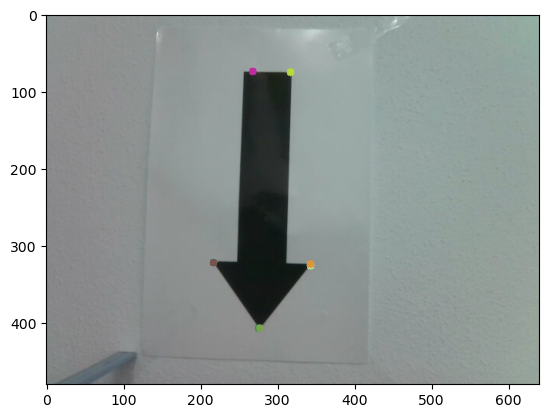

In [11]:
import random

for idx in range(len(points)):
    red = random.randint(0, 255)
    green = random.randint(0, 255)
    blue = random.randint(0, 255)

    cv2.circle(
        img,
        (points[idx, 0, 0], points[idx, 0, 1]),
        5,
        (red, green, blue),
        thickness=-1
    )

plt.imshow(img)
plt.show()

In [12]:
MAX_MERGE_DIST = 4

to_merge = []
checked_points_idx = []
last_to_merge = False
for idx in range(len(points)-1):
    first_point = points[idx, 0]
    print(f'first:{first_point}')
    if idx not in checked_points_idx:
        to_merge_bundle = [first_point]
        
        for idx2 in range(idx+1, len(points)):
            second_point = points[idx2, 0]
            dist = np.abs(first_point - second_point)
            
            if dist[0] < MAX_MERGE_DIST and dist[1] < MAX_MERGE_DIST:
                to_merge_bundle.append(second_point)
                checked_points_idx.append(idx2)
                if idx2 == len(points)-1:
                    last_to_merge = True
                    print(f'last:{second_point}')
                print(f'{first_point}:{second_point}')

        to_merge.append(to_merge_bundle)

if not last_to_merge:
    to_merge.append([points[-1, 0]])
    print('added last')

first:[317  75]
first:[217 321]
[217 321]:[217 322]
first:[276 407]
[276 407]:[277 407]
first:[343 326]
last:[343 324]
[343 326]:[343 324]
first:[277 407]
first:[217 322]
first:[268  74]


In [13]:
to_merge

[[array([317,  75], dtype=int32)],
 [array([217, 321], dtype=int32), array([217, 322], dtype=int32)],
 [array([276, 407], dtype=int32), array([277, 407], dtype=int32)],
 [array([343, 326], dtype=int32), array([343, 324], dtype=int32)],
 [array([268,  74], dtype=int32)]]

In [14]:
filtered_points = []
for to_merge_bundle in to_merge:
    if len(to_merge_bundle) == 1:
        filtered_points.append(to_merge_bundle[0])
    else:
        filtered_point = np.sum(to_merge_bundle, axis=0)/ len(to_merge_bundle)
        filtered_points.append(filtered_point)

print(filtered_points)

[array([317,  75], dtype=int32), array([217. , 321.5]), array([276.5, 407. ]), array([343., 325.]), array([268,  74], dtype=int32)]


In [15]:
print(len(filtered_points))

5


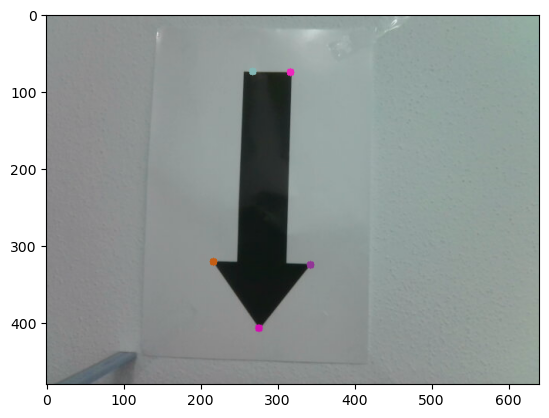

In [16]:
img = ref_img.copy()

for idx in range(len(filtered_points)):
    red = random.randint(0, 255)
    green = random.randint(0, 255)
    blue = random.randint(0, 255)

    cv2.circle(
        img,
        (int(filtered_points[idx][0]), int(filtered_points[idx][1])),
        5,
        (red, green, blue),
        thickness=-1
    )
    
plt.imshow(img)
plt.show()

In [17]:
ref_points = filtered_points

## Add reference data

In [18]:
points_printed = np.loadtxt('../coords_of_arrow.txt')
points_printed

array([[   0., -118.],
       [  45.,  -61.],
       [ -45.,  -61.],
       [ -22.,  118.],
       [  22.,  118.]])

In [50]:
points_printed = points_printed[np.lexsort((points_printed[:,1], points_printed[:,0]))] # start with most left
points_printed

array([[ -45.,  -61.],
       [ -22.,  118.],
       [   0., -118.],
       [  22.,  118.],
       [  45.,  -61.]])

In [54]:
img_points = np.array(ref_points)
img_points = img_points[np.lexsort((img_points[:,1], img_points[:,0]))]
img_points

array([[217. , 321.5],
       [268. ,  74. ],
       [276.5, 407. ],
       [317. ,  75. ],
       [343. , 325. ]])

In [55]:
H, mask = cv2.findHomography(points_printed, img_points, cv2.RANSAC)
print(H)

[[ 1.27634984e+00  4.51664589e-01  2.84846607e+02]
 [ 2.34375693e-02 -1.17893578e+00  2.25244551e+02]
 [-3.80908115e-05  1.32300620e-03  1.00000000e+00]]


In [56]:
K = np.loadtxt('../../cam-config/mtx.txt')
K

array([[655.19135007,   0.        , 319.04529769],
       [  0.        , 655.56447367, 223.19439802],
       [  0.        ,   0.        ,   1.        ]])

In [57]:
dist = np.loadtxt('../../cam-config/dist.txt')
dist

array([ 0.07963989, -0.27691914, -0.00549367,  0.00080431, -0.48606527])

In [58]:
H = H.T
h1 = H[0]
h2 = H[1]
h3 = H[2]
K_inv = np.linalg.inv(K)
L = 1 / np.linalg.norm(np.dot(K_inv, h1))
r1 = L * np.dot(K_inv, h1)
r2 = L * np.dot(K_inv, h2)
r3 = np.cross(r1, r2)

T0 = L * np.dot(K_inv, h3)
print(T0)
T = L * (K_inv @ h3.reshape(3, 1))

# TODO
# R = np.array([[r1], [r2], [r3]])
# R = np.reshape(R, (3, 3))
# print(R)
print(T)

[-26.52830963   1.58942135 508.23930488]
[[-26.52830963]
 [  1.58942135]
 [508.23930488]]


508.23930488 mm ~ 500 mm == 50 cm => looks good

## 70 cm test

In [19]:
img_filename = '../70_cm.jpg'

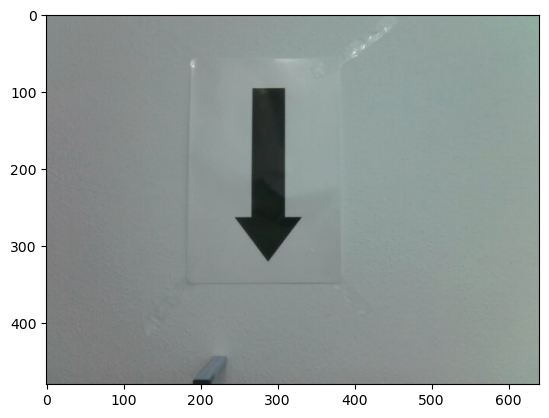

In [20]:
org_img = cv2.imread(img_filename)
if ref_img is not None:
    plt.imshow(org_img)
    plt.show()

model already loaded
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
(1, 1)
[[0.9998861]]


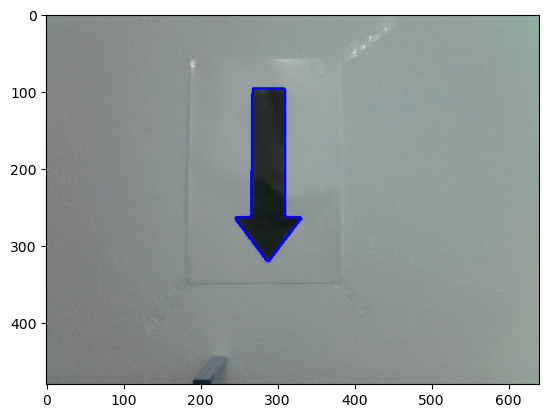

done


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

if not 'model' in dir():
    print('load model...')
    from keras.models import load_model
    model = load_model('arrow_detection.keras')
    print('loaded model')
    
else:
    print('model already loaded')
    
model.trainable = False

COMPARED_SIZE = (24, 68)
AREA_BORDER = COMPARED_SIZE[0] * COMPARED_SIZE[1]
WIDTH_TO_HEIGHT = COMPARED_SIZE[0] / COMPARED_SIZE[1]
SIZE_FACTOR = 0.3
MIN_WIDTH_TO_HEIGHT = WIDTH_TO_HEIGHT * (1 - SIZE_FACTOR)
MAX_WIDTH_TO_HEIGHT = WIDTH_TO_HEIGHT * (1 + SIZE_FACTOR)

def prepare_rotation(min_rect):
    """
    Prepare portrait rotation. No difference between up and down.
    """
    
    width_to_height = min_rect[1][0] / min_rect[1][1]
    
    if width_to_height >= 1:
        return 90 - min_rect[2]
    else:
        return min_rect[2]

def rotate_and_crop_min_rect(image, min_area_rect):
    factor = 1.3

    box = cv2.boxPoints(min_area_rect)
    box = np.intp(box)

    width = round(min_area_rect[1][0])
    height = round(min_area_rect[1][1])

    size_of_transformed_image = max(min_area_rect[1])
    min_needed_height = int(np.sqrt(2 * np.power(size_of_transformed_image, 2)))

    #angle = prepare_rotation(min_area_rect)
    width_to_height = min_area_rect[1][0] / min_area_rect[1][1]
    
    if width_to_height >= 1:
        angle = -1 * (90 - min_rect[2])
    else:
        angle = min_rect[2]    
        
    size = (min_needed_height, min_needed_height)

    x_coordinates_of_box = box[:,0]
    y_coordinates_of_box = box[:,1]
    x_min = min(x_coordinates_of_box)
    x_max = max(x_coordinates_of_box)
    y_min = min(y_coordinates_of_box)
    y_max = max(y_coordinates_of_box)

    center = (int((x_min+x_max)/2), int((y_min+y_max)/2))
    cropped = cv2.getRectSubPix(image, size, center) 
    M = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)
    cropped = cv2.warpAffine(cropped, M, size)
    
    if width_to_height >= 1:
        cropped_rotated = cv2.getRectSubPix(cropped, (int(factor * height), int(factor * width)), (size[0]/2, size[1]/2))
    else:
        cropped_rotated = cv2.getRectSubPix(cropped, (int(factor * width), int(factor * height)), (size[0]/2, size[1]/2))

    return cropped_rotated


img = cv2.imread(img_filename)

if img is None:
    raise IOError('file not valid')

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.blur(gray_img, (3,3))

sigma = 0.33
v = np.median(blurred)

#---- apply automatic Canny edge detection using the computed median----
lower = int(max(0, (1.0 - sigma) * v))    #---- lower threshold
upper = int(min(255, (1.0 + sigma) * v))  #---- upper threshold
thresh_img = cv2.Canny(blurred, lower, upper)
cnts, _ = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

filtered_list = []
pos_filtered_to_pos_source = {}
pos_filtered = 0
center_list = []
too_close = False
for pos_source, con in enumerate(cnts):
    min_rect = cv2.minAreaRect(con)
    center, size, angle = min_rect
    area = size[0] * size[1]

    if area < AREA_BORDER:
        continue

    low_value = min(size[0], size[1])
    high_value = max(size[0], size[1])
    width_to_height = low_value / high_value

    if MIN_WIDTH_TO_HEIGHT < width_to_height < MAX_WIDTH_TO_HEIGHT:
        for c_point in center_list:
            too_close = np.all(np.isclose(center, c_point, rtol=0, atol=20))
            if too_close:
                break

        if too_close:
            continue
        center_list.append(center)
        cropped_img = rotate_and_crop_min_rect(gray_img, min_rect)
        small_img = cv2.resize(cropped_img, COMPARED_SIZE)
        filtered_list.append(small_img)
        pos_filtered_to_pos_source[pos_filtered] = pos_source
        pos_filtered += 1

filtered_list = np.array(filtered_list)
prediction = model.predict(filtered_list)
print(prediction.shape)
print(prediction)

positive_centers = []
positive_contours = []
negative_contours = []

for pos, value in enumerate(prediction):
    idx = pos_filtered_to_pos_source[pos]
    if value[0] >= 0.5:
        positive_contours.append(cnts[idx])
        positive_centers.append(center_list[pos])
    else:
        negative_contours.append(cnts[idx])

cv2.drawContours(img, positive_contours, -1, (0,0,255), 2)
cv2.drawContours(img, negative_contours, -1, (255,0,0), 2)

plt.imshow(img)
plt.show()
print('done')


In [22]:
positive_contours[0].shape

(71, 1, 2)

In [23]:
M = cv2.moments(positive_contours[0])
if (M["m00"] != 0):
    x_c = int(M["m10"] / M["m00"])
    y_c = int(M["m01"] / M["m00"])
else:
    x_c = -1
    y_c = -1
retval = cv2.arcLength(positive_contours[0], True)
points = cv2.approxPolyDP(positive_contours[0], 0.04 * retval, True)

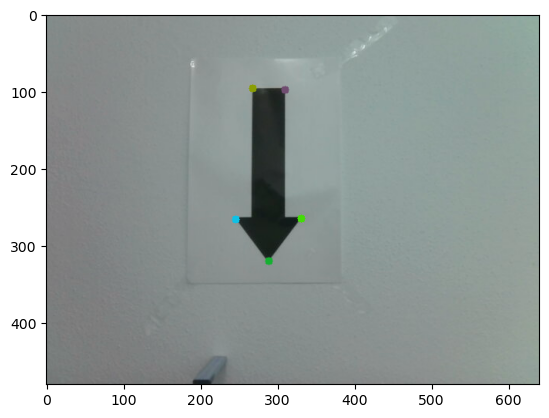

5


In [24]:
import random

img = org_img.copy()

for idx in range(len(points)):
    red = random.randint(0, 255)
    green = random.randint(0, 255)
    blue = random.randint(0, 255)

    cv2.circle(
        img,
        (points[idx, 0, 0], points[idx, 0, 1]),
        5,
        (red, green, blue),
        thickness=-1
    )

plt.imshow(img)
plt.show()
print(len(points))

In [25]:
MAX_MERGE_DIST = 4

to_merge = []
checked_points_idx = []
last_to_merge = False
for idx in range(len(points)-1):
    first_point = points[idx, 0]
    print(f'first:{first_point}')
    if idx not in checked_points_idx:
        to_merge_bundle = [first_point]
        
        for idx2 in range(idx+1, len(points)):
            second_point = points[idx2, 0]
            dist = np.abs(first_point - second_point)
            
            if dist[0] < MAX_MERGE_DIST and dist[1] < MAX_MERGE_DIST:
                to_merge_bundle.append(second_point)
                checked_points_idx.append(idx2)
                if idx2 == len(points)-1:
                    last_to_merge = True
                    print(f'last:{second_point}')
                print(f'{first_point}:{second_point}')

        to_merge.append(to_merge_bundle)

if not last_to_merge:
    to_merge.append([points[-1, 0]])
    print(f'added last: {points[-1, 0]}')

first:[268  96]
first:[246 266]
first:[289 320]
first:[331 265]
added last: [310  98]


In [26]:
to_merge

[[array([268,  96], dtype=int32)],
 [array([246, 266], dtype=int32)],
 [array([289, 320], dtype=int32)],
 [array([331, 265], dtype=int32)],
 [array([310,  98], dtype=int32)]]

In [27]:
filtered_points = []
for to_merge_bundle in to_merge:
    if len(to_merge_bundle) == 1:
        filtered_points.append(to_merge_bundle[0])
    else:
        filtered_point = np.sum(to_merge_bundle, axis=0)/ len(to_merge_bundle)
        filtered_points.append(filtered_point)

print(filtered_points)

[array([268,  96], dtype=int32), array([246, 266], dtype=int32), array([289, 320], dtype=int32), array([331, 265], dtype=int32), array([310,  98], dtype=int32)]


In [28]:
print(len(filtered_points))

5


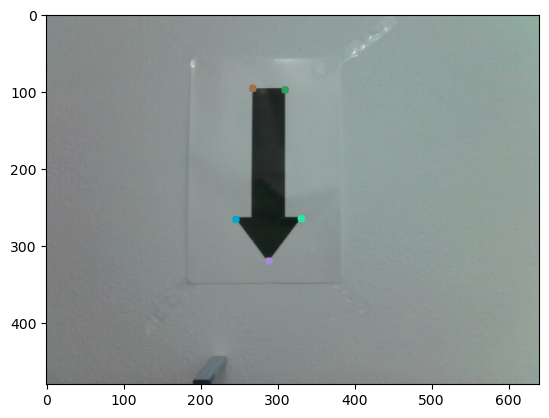

In [29]:
img = org_img.copy()

for idx in range(len(filtered_points)):
    red = random.randint(0, 255)
    green = random.randint(0, 255)
    blue = random.randint(0, 255)

    cv2.circle(
        img,
        (int(filtered_points[idx][0]), int(filtered_points[idx][1])),
        5,
        (red, green, blue),
        thickness=-1
    )
    
plt.imshow(img)
plt.show()

In [59]:
filtered_points

[array([268,  96], dtype=int32),
 array([246, 266], dtype=int32),
 array([289, 320], dtype=int32),
 array([331, 265], dtype=int32),
 array([310,  98], dtype=int32)]

In [61]:
img_points = np.array(filtered_points)
img_points = img_points[np.lexsort((img_points[:,1], img_points[:,0]))]
img_points

array([[246, 266],
       [268,  96],
       [289, 320],
       [310,  98],
       [331, 265]], dtype=int32)

In [62]:
H, mask = cv2.findHomography(points_printed, img_points, cv2.RANSAC)
print(H)

[[ 1.04008053e+00  1.20840851e-02  2.89112620e+02]
 [ 7.64158998e-02 -9.35822383e-01  2.07868696e+02]
 [ 3.28314882e-04  4.04778480e-05  1.00000000e+00]]


In [63]:
H = H.T
h1 = H[0]
h2 = H[1]
h3 = H[2]
K_inv = np.linalg.inv(K)
L = 1 / np.linalg.norm(np.dot(K_inv, h1))
r1 = L * np.dot(K_inv, h1)
r2 = L * np.dot(K_inv, h2)
r3 = np.cross(r1, r2)

T0 = L * np.dot(K_inv, h3)
print(T0)
T = L * (K_inv @ h3.reshape(3, 1))

# TODO
# R = np.array([[r1], [r2], [r3]])
# R = np.reshape(R, (3, 3))
# print(R)
print(T)

[-31.18782695 -15.95925727 682.66510184]
[[-31.18782695]
 [-15.95925727]
 [682.66510184]]


682.66510184 mm ~ 683 mm == 68.3 cm => close to 70 cm